In [23]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_grid(size):
    grid = np.zeros((size, size), dtype=int)
    center = size // 2
    grid[center, center] = 1
    return grid, set([(center, center)]), set([(center, center)])

def get_moore_neighborhood(x, y, size):
    neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1),
                 (x + 1, y + 1), (x - 1, y - 1), (x + 1, y - 1), (x - 1, y + 1)]
    return [(nx, ny) for nx, ny in neighbors if 0 <= nx < size and 0 <= ny < size]

def draw_circular_wall(grid, size, radius):
    center = size // 2
    for x in range(size):
        for y in range(size):
            if (x - center) ** 2 + (y - center) ** 2 > radius ** 2:
                grid[x, y] = -1  # Use -1 to indicate the wall
    return grid

def grow_cluster(grid, border, dividing_cells, iterations, base_growth_rate, base_death_prob, radius):
    size = len(grid)
    population_size = [1]
    time_points = [0]

    center = size // 2

    def is_within_circle(x, y):
        return (x - center) ** 2 + (y - center) ** 2 <= radius ** 2

    for _ in range(iterations):
        if not border:
            break

        N = np.sum(grid > 0)  # Only count actual cells, not walls
        num_dividing_cells = len(dividing_cells)

        summed_death = base_death_prob * N
        summed_birth = base_growth_rate * num_dividing_cells

        total_rate = summed_death + summed_birth
        if total_rate == 0:
            break

        #next_event_time = np.random.exponential(1 / total_rate)
        #time_points.append(time_points[-1] + next_event_time)

        if np.random.rand() < summed_birth / total_rate:
            new_site = list(border)[np.random.randint(len(border))]
            if is_within_circle(new_site[0], new_site[1]):
                grid[new_site] = 1
                border.remove(new_site)
                #dividing_cells.add(new_site)

                # Update border
                for nx, ny in get_moore_neighborhood(*new_site, size):
                    if grid[nx, ny] == 0 and is_within_circle(nx, ny):
                        border.add((nx, ny))

                    if grid[nx, ny] == 1 and is_within_circle(nx, ny): # If there is a cell at these coords, and is inside the bounding space
                        if not all(grid[nxx, nyy] == 1 for nxx, nyy in get_moore_neighborhood(nx, ny, size) if is_within_circle(nxx, nyy)): # Check if neighborhood of this cell is not completely filled with other cells, thus this cell is able to divide
                            dividing_cells.add((nx, ny))
                        elif ((nx, ny) in dividing_cells): # If this cell is completely surrounded by other cells, but is included in dividing_cells, we need to remove it as it now is unable to divide
                            dividing_cells.remove((nx, ny))

                if not all(grid[nx, ny] == 1 for nx, ny in get_moore_neighborhood(*new_site, size)): # Check if neighborhood of this *new_site is not completely filled, thus this cell is able to divide
                    dividing_cells.add(new_site)
                        
                border = set(border)
                dividing_cells = set(dividing_cells)
        else:
            living_cells = np.argwhere(grid == 1).tolist() # Get the coordinates of all the currently living cells
            if living_cells:
                death_site = tuple(living_cells[np.random.randint(len(living_cells))])
                grid[death_site] = 0
                
                if death_site in dividing_cells: # Check if the death site is a dividing cell and therefore needs to be removed from dividing cells
                    dividing_cells.remove(death_site)

                # Update border and dividing_cells for death_site
                for nx, ny in get_moore_neighborhood(*death_site, size):
                    if grid[nx, ny] == 1 and is_within_circle(nx, ny):
                        border.add((nx, ny))
                
                if is_within_circle(nx, ny) and grid[nx, ny] == 0:
                    if any(grid[nxx, nyy] == 1 for nxx, nyy in get_moore_neighborhood(nx, ny, size) if is_within_circle(nxx, nyy)):
                        border.add((nx, ny))
                    elif (nx, ny) in border:
                        border.remove((nx, ny))

                    #87 if grid[nx, ny] == 1 and is_within_circle(nx, ny):  # If there is a cell at these coords, and is inside the bounding space
                    #88    if not all(grid[nxx, nyy] == 1 for nxx, nyy in get_moore_neighborhood(nx, ny, size) if is_within_circle(nxx, nyy)):  # Check if neighborhood of this cell is not completely filled with other cells, thus this cell is able to divide
                    #89         dividing_cells.add((nx, ny))
                    #90     elif ((nx, ny) in dividing_cells):  # If this cell is completely surrounded by other cells, but is included in dividing_cells, we need to remove it as it now is unable to divide
                    #91         dividing_cells.remove((nx, ny))
                
                # Check if death_site should be added to border
                if any(grid[nx, ny] == 1 for nx, ny in get_moore_neighborhood(*death_site, size)):
                    if is_within_circle(death_site[0], death_site[1]):
                        border.add(death_site)

                border = set(border)
                dividing_cells = set(dividing_cells)
            
            else:
                print("false")
        
        # update time and population at the end of the iteration
        next_event_time = np.random.exponential(1 / total_rate)
        time_points.append(time_points[-1] + next_event_time)

        population_size.append(np.sum(grid > 0))

    return grid, population_size, time_points

def plot_grid(grid):
    # Set up color map
    cmap = plt.cm.Greys
    norm = plt.Normalize(vmin=-1, vmax=1)

    # Create a custom color map
    custom_cmap = cmap(np.arange(cmap.N))
    custom_cmap[0, :3] = 0.7, 0.7, 0.7  # Set the color for -1 (walls) to grey
    custom_cmap[1, :3] = 1, 1, 1  # Set the color for 0 (empty) to white
    custom_cmap = plt.matplotlib.colors.ListedColormap(custom_cmap)

    plt.imshow(grid, cmap=custom_cmap, norm=norm, interpolation='nearest')
    plt.title('Eden Growth Model with Circular Wall')
    plt.axis('off')
    plt.show()



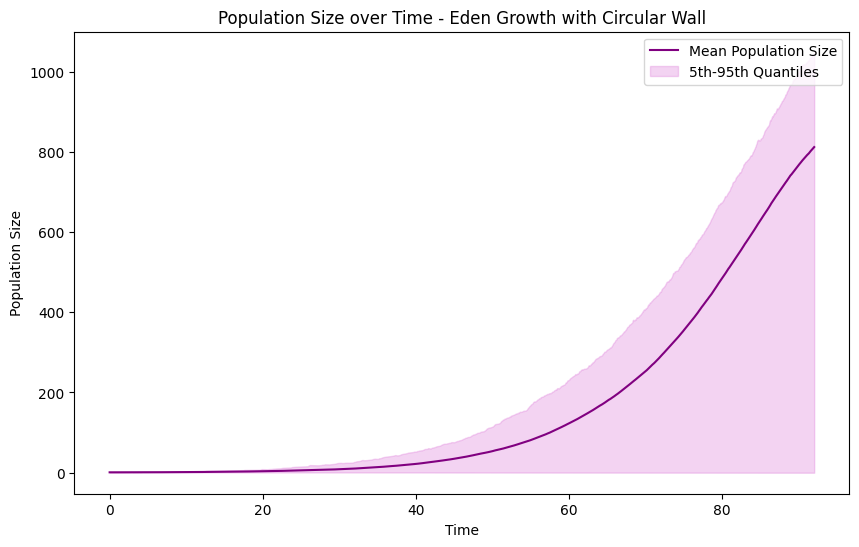

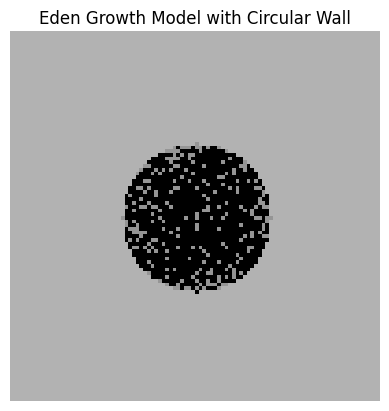

Extinction rate: 19.00%


In [24]:
# Parameters
grid_size = 100
iterations = 2000
base_growth_rate = 0.1
base_death_prob = 0.01
num_simulations = 100
radius = 20  # Adjust this value to change the size of the circular wall

# Run multiple simulations
all_population_sizes = []
all_time_points = []
extinction_count = 0

for _ in range(num_simulations):
    grid, border, dividing_cells = initialize_grid(grid_size)
    grid = draw_circular_wall(grid, grid_size, radius)
    grid, population_size, time_points = grow_cluster(grid, border, dividing_cells, iterations, base_growth_rate, base_death_prob, radius)

    if population_size[-1] == 0:
        extinction_count += 1

    all_population_sizes.append(np.interp(np.linspace(0, max(time_points), iterations), time_points, population_size))
    all_time_points.append(np.linspace(0, max(time_points), iterations))

all_population_sizes = np.array(all_population_sizes)
time_points = np.mean(all_time_points, axis=0)

# Calculate quantiles
quantiles_5 = np.percentile(all_population_sizes, 5, axis=0)
quantiles_95 = np.percentile(all_population_sizes, 95, axis=0)
mean_population_size = np.mean(all_population_sizes, axis=0)

# Calculate extinction rate
extinction_rate = (extinction_count / num_simulations) * 100

# Plot population size over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, mean_population_size, label='Mean Population Size', color='purple')
plt.fill_between(time_points, quantiles_5, quantiles_95, color='orchid', alpha=0.3, label='5th-95th Quantiles')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Population Size over Time - Eden Growth with Circular Wall')
plt.legend()
plt.show()

# Plot final grid of the last simulation
plot_grid(grid)

# Display extinction rate
print(f"Extinction rate: {extinction_rate:.2f}%")